In [1]:
import numpy as np
import datetime as dt

import scipy.signal as ss
import matplotlib.pyplot as plt

import pyxu.operator as pxop
import pyxu.opt.stop as pxos

import pyfwl

# Simulate the problem

In [2]:
seed = 42
rng = np.random.default_rng(seed)

In [3]:
N = 100
k = 10
L = 3 * k
psnrdb = 20

sigma = 2
Nl = N + 6 * int(sigma)

convop = 2 * pxop.Gaussian((Nl, ), sigma=sigma)
samples = rng.choice(Nl, size=L, replace=False)
S = pxop.SubSample((Nl, ), samples)

fOp = S * convop
fOp.lipschitz = fOp.estimate_lipschitz(method='svd', tol=1.e-2)

In [4]:
supp = rng.choice(N, size=k, replace=False) + 3 * int(sigma)
x = np.zeros(N + 6 * int(sigma))
x[supp] = rng.uniform(2, 6, size=k)

g = convop(x)
noiselessy = fOp(x)
std = np.max(np.abs(noiselessy)) * 10 ** (-psnrdb / 20)
noise = rng.normal(0, std, size=L)

y = noiselessy + noise

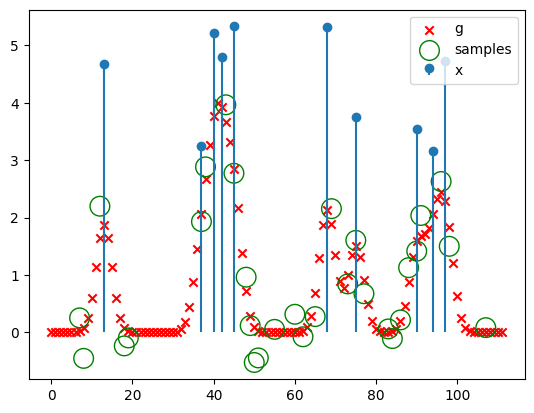

In [5]:
plt.figure()
m, s, b = plt.stem(np.where(x>0)[0], x[x>0], label='x')
b._visible = False
plt.scatter(np.arange(Nl), g, label='g', marker='x', color='r')
plt.scatter(samples, y, label='samples', marker='o', color='none', edgecolors='g', s=200)
plt.legend()
plt.show()

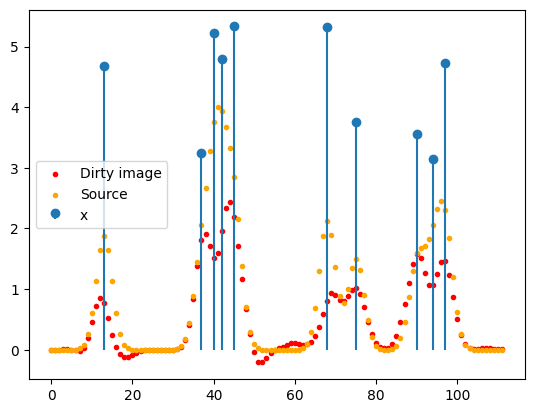

In [6]:
## Dual certificate
d = fOp.adjoint(y)

plt.figure()
plt.scatter(np.arange(Nl), d, marker='.', color='r', label="Dirty image")
plt.scatter(np.arange(Nl), g, marker='.', color='orange', label="Source")
_, _, b = plt.stem(np.where(x>0)[0], x[x>0], label='x')
b._visible = False
plt.legend()
plt.show()

# Solve with PFW

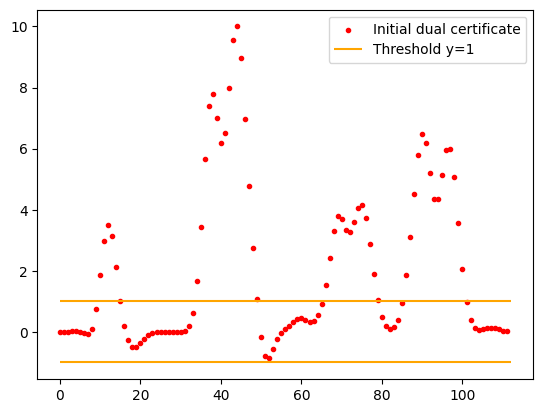

In [7]:
lambda_factor = 0.1
lambda_ = lambda_factor * np.max(np.abs(d))

eps = 1e-2
min_iterations = 10

# plot dual certificate at beginning
plt.figure()
plt.scatter(np.arange(Nl), d/lambda_, marker='.', color='r', label="Initial dual certificate")
plt.hlines([-1, 1], 0, Nl, color='orange', label="Threshold y=1")
plt.legend()
plt.show()

In [8]:
stop_crit = pxos.RelError(
    eps=eps,
    var="objective_func",
    f=None,
    norm=2,
    satisfy_all=True,
)

# Minimum number of iterations
min_iter = pxos.MaxIter(n=min_iterations)
#Maximum runtime
tmax = 15
# track DCV
track_dcv = pxos.AbsError(eps=1e-10, var="dcv", f=None, norm=2, satisfy_all=True)
stop_crit = (min_iter & stop_crit) | pxos.MaxDuration(t=dt.timedelta(seconds=tmax)) | track_dcv

## Regular PFW

In [9]:
pfw = pyfwl.PFWLasso(y, fOp, lambda_,
                     ms_threshold=0.9,
                     final_correction_prec=eps)

pfw.fit(stop_crit=stop_crit, verbose=50, 
        precision_rule=lambda k : 10**(-k/10))

Computation of diff_lipschitz takes 0.103
INFO -- [2024-01-18 11:36:02.988872] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[objective_func]: 0.0
	duration: 0.012666
	AbsError[dcv]: inf
	Memorize[objective_func]: 33.63058816598042
INFO -- [2024-01-18 11:36:03.215425] Iteration 10
	iteration: 10
	N_iter: 11.0
	RelError[objective_func]: 0.0015513495302612234
	duration: 0.239282
	AbsError[dcv]: 1.1176101008735537
	Memorize[objective_func]: 10.564236381187001
INFO -- [2024-01-18 11:36:03.215962] Stopping Criterion satisfied -> END


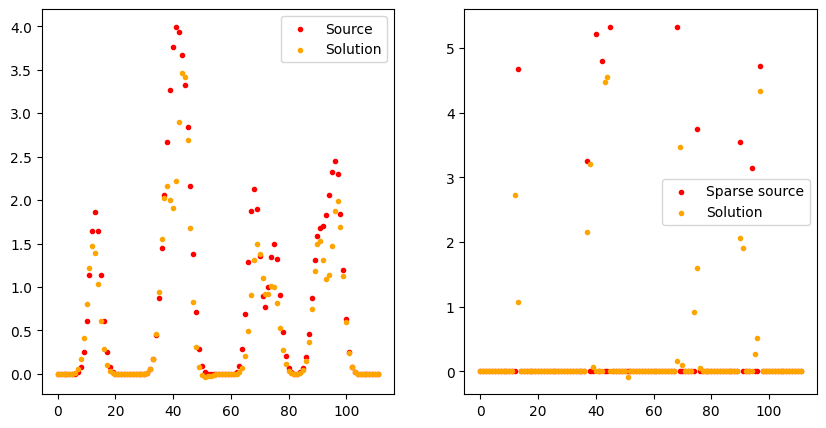

In [10]:
solpfw = pfw.stats()[0]['x']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(np.arange(Nl), g, marker='.', color='r', label="Source")
plt.scatter(np.arange(Nl), convop(solpfw), marker='.', color='orange', label="Solution")
plt.legend()

plt.subplot(122)
plt.scatter(np.arange(Nl), x, marker='.', color='r', label="Sparse source")
plt.scatter(np.arange(Nl), solpfw, marker='.', color='orange', label="Solution")
plt.legend()
plt.show()

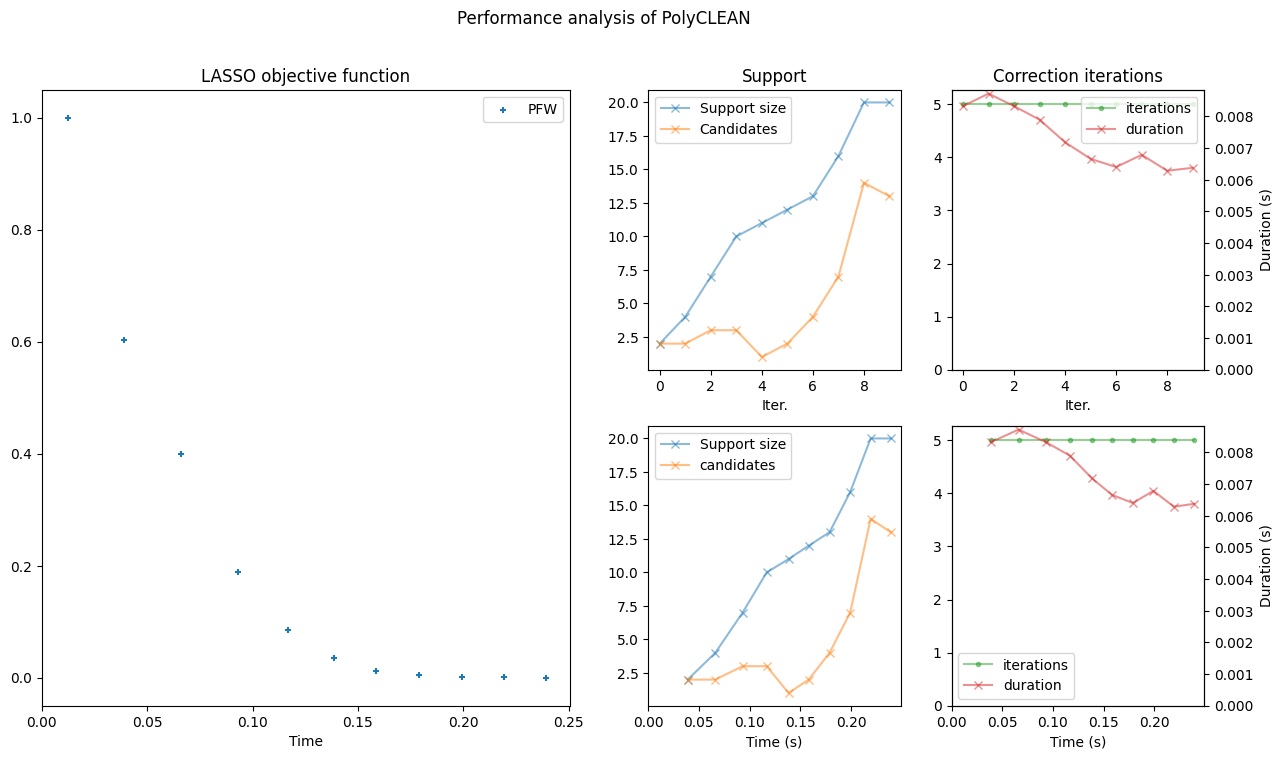

In [11]:
pfw.diagnostics()

## Solve with LocalMaxPFW

In [12]:
from pyfwl import LocalMaxPFW

lmpfw = LocalMaxPFW(y, fOp, lambda_, final_correction_prec=eps)

lmpfw.fit(stop_crit=stop_crit, verbose=50, 
          precision_rule=lambda k : 10**(-k/10))


Computation of diff_lipschitz takes 0.057
INFO -- [2024-01-18 11:36:04.177217] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[objective_func]: 0.0
	duration: 0.017223
	AbsError[dcv]: inf
	Memorize[objective_func]: 33.63058816598042
INFO -- [2024-01-18 11:36:04.408982] Iteration 10
	iteration: 10
	N_iter: 11.0
	RelError[objective_func]: 0.0006872561426861125
	duration: 0.24902
	AbsError[dcv]: 1.0777081819971683
	Memorize[objective_func]: 10.409894842947008
INFO -- [2024-01-18 11:36:04.409442] Stopping Criterion satisfied -> END


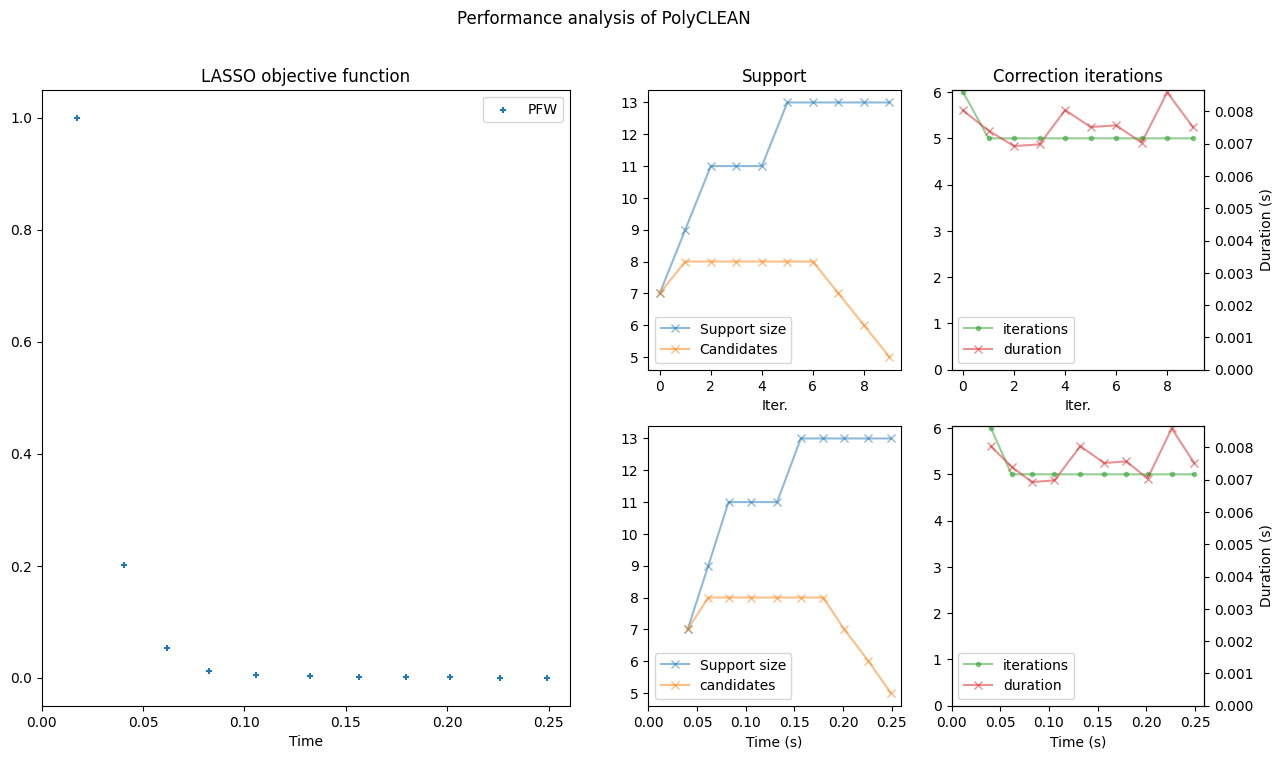

In [13]:
lmpfw.diagnostics()

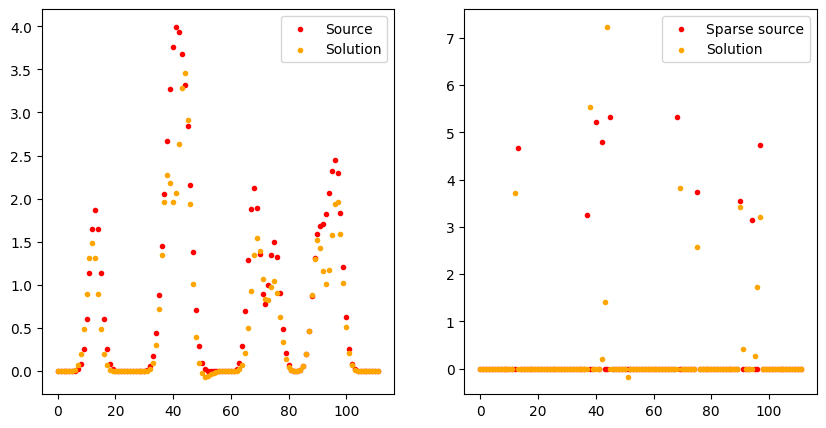

In [14]:
sollm = lmpfw.stats()[0]['x']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(np.arange(Nl), g, marker='.', color='r', label="Source")
plt.scatter(np.arange(Nl), convop(sollm), marker='.', color='orange', label="Solution")
plt.legend()

plt.subplot(122)
plt.scatter(np.arange(Nl), x, marker='.', color='r', label="Sparse source")
plt.scatter(np.arange(Nl), sollm, marker='.', color='orange', label="Solution")
plt.legend()
plt.show()

# Compare the solution of PFW and LMPFW

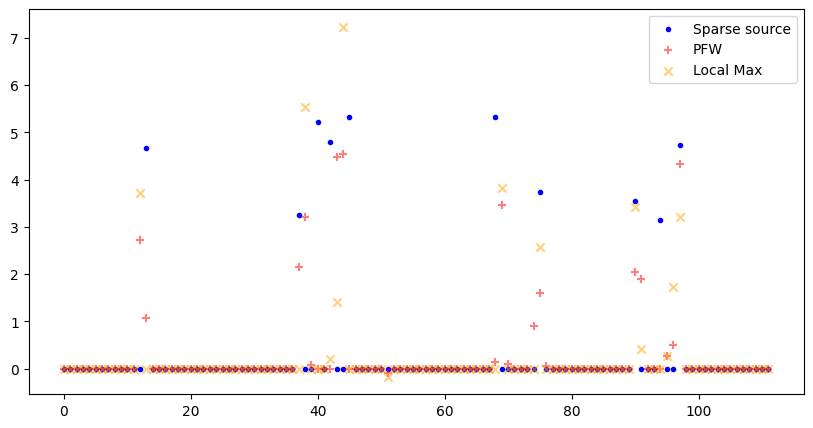

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(Nl), x, marker='.', color='b', label="Sparse source")
plt.scatter(np.arange(Nl), solpfw, marker='+', color='r', label="PFW", alpha=.5)
plt.scatter(np.arange(Nl), sollm, marker='x', color='orange', label="Local Max", alpha=.5)
plt.legend()
plt.show()

## Solve with PGD

In [16]:
from pyxu.opt.solver import PGD

# Explicit definition of the objective function for APGD
data_fid = 0.5 * pxop.SquaredL2Norm(dim=fOp.shape[0]).argshift(-y) * fOp
regul = lambda_ * pxop.L1Norm(N)

print("Solving with APGD: ...")
pgd = PGD(data_fid, regul, verbosity=50)
pgd.fit(
    x0=np.zeros(Nl, dtype="float64"),
    stop_crit=(min_iter & pgd.default_stop_crit()) | pxos.MaxDuration(t=dt.timedelta(seconds=tmax)),
    track_objective=True,
    tau=1 / fOp.lipschitz ** 2,
)
sol_apgd = pgd.stats()[0]["x"]

Solving with APGD: ...
INFO -- [2024-01-18 11:36:05.633253] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
	duration: 0.001557
	Memorize[objective_func]: 33.63058816598042
INFO -- [2024-01-18 11:36:05.745935] Iteration 50
	iteration: 50
	N_iter: 51.0
	RelError[x]: 0.00818904490511876
	duration: 0.114308
	Memorize[objective_func]: 10.604848154133881
INFO -- [2024-01-18 11:36:05.858769] Iteration 100
	iteration: 100
	N_iter: 101.0
	RelError[x]: 0.005846339036509851
	duration: 0.227139
	Memorize[objective_func]: 10.442302080194358
INFO -- [2024-01-18 11:36:05.956608] Iteration 150
	iteration: 150
	N_iter: 151.0
	RelError[x]: 0.004770437190588996
	duration: 0.324966
	Memorize[objective_func]: 10.335522785752584
INFO -- [2024-01-18 11:36:06.073362] Iteration 200
	iteration: 200
	N_iter: 201.0
	RelError[x]: 0.0024418889783006203
	duration: 0.441729
	Memorize[objective_func]: 10.282400131535894
INFO -- [2024-01-18 11:36:06.156238] Iteration 250
	iteration: 250
	N_iter: 251.0
	RelErr

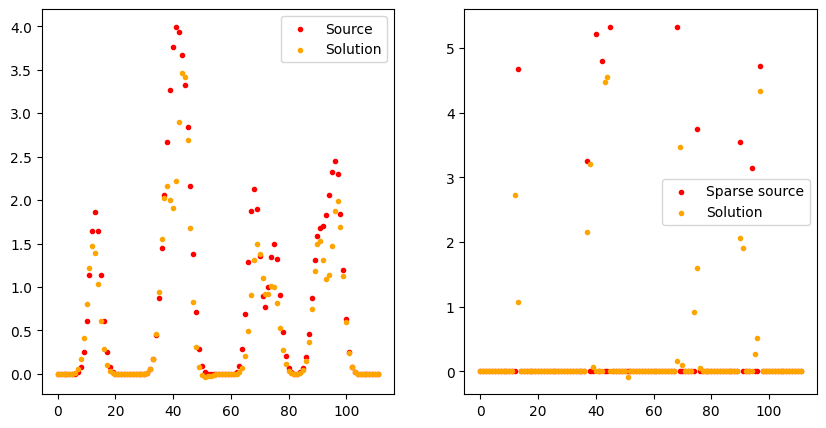

In [17]:
sol = pfw.stats()[0]['x']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(np.arange(Nl), g, marker='.', color='r', label="Source")
plt.scatter(np.arange(Nl), convop(sol), marker='.', color='orange', label="Solution")
plt.legend()

plt.subplot(122)
plt.scatter(np.arange(Nl), x, marker='.', color='r', label="Sparse source")
plt.scatter(np.arange(Nl), sol, marker='.', color='orange', label="Solution")
plt.legend()
plt.show()

# 2D

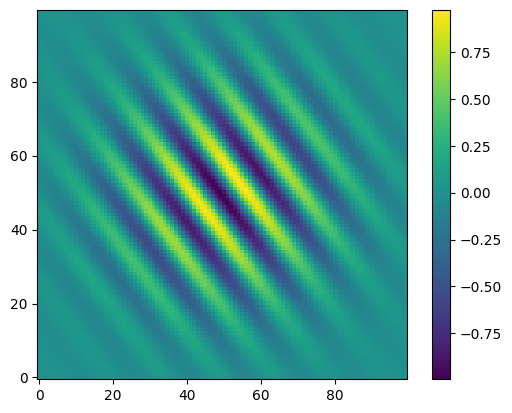

In [18]:
N = 100
a, b = 15, 20
# create a 2d sinusoidal image of size N x N
xx, yy = np.meshgrid(np.arange(N), np.arange(N))
z = np.sin(2 * np.pi * (xx / a + yy /b)) * np.exp(-0.001 * ((xx - 50)**2 + (yy-50)**2))
plt.figure()
plt.imshow(z, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()


In [22]:
import skimage.feature as skf

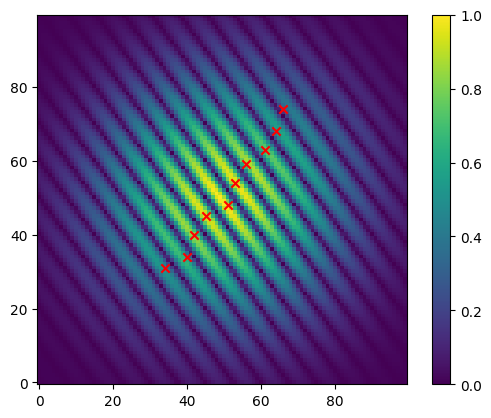

In [29]:
skf.peak_local_max(z, threshold_abs=.4)

z = np.abs(z)

plt.figure()
plt.imshow(z, origin='lower', cmap='viridis')
for (x, y) in skf.peak_local_max(z, threshold_abs=.4, min_distance=3):
    plt.scatter(x, y, marker='x', color='r')
plt.colorbar()
plt.show()
